<h1>1) Grundlagen und Datenaufbereitung Sequenzdaten </h1>
<h4>Dienstag 04.06.24 13:30 – 17:00 Uhr</h4>
<br>
--- <br>
<strong>1.1 Zeitreihen als Beispiel für Sequenzdaten </strong><br>
<strong>1.2 Daten aufbereiten und Zeitreihen vorhersagen</strong><br>
---

In [1]:
# Für Zeitreihenoperationen 
import pandas as pd
import numpy as np

# Zum Plotten
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Für Autokorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Für Stationarität
from statsmodels.tsa.stattools import adfuller

# Für Komponentenzerlegung
from statsmodels.tsa.seasonal import seasonal_decompose

# Für die Auswertung
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Zum Ignorieren nerviger Warnungen (könnt ihr auch erstmal weglassen und Warnungen anzeigen lassen)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Zum GPU Teilen
#from utils_code.share_gpu import restrict_gpu_memory
#restrict_gpu_memory(4500)

# 1.1 Zeitreihen als Beispiel für Sequenzdaten

### Daten: Energiezeitreihen


In [3]:
ene = pd.read_csv("germany_fossil_renew.csv", sep=";")

In [4]:
ene.head()

,Datum,Fossile,Wind,Solar
0,01/2016,37521,9771,702
1,02/2016,32023,10371,1350
2,03/2016,35256,6331,2591
3,04/2016,30078,6235,4129
4,05/2016,27404,6445,5190


In [5]:
ene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Datum    58 non-null     object
 1   Fossile  58 non-null     int64 
 2   Wind     58 non-null     int64 
 3   Solar    58 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.9+ KB


In [6]:
ene['Datum'] = pd.to_datetime(ene['Datum'])
ene['Datum'].freq = 'M'
ene.head()

c:\temp\ipykernel_18552\156820959.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ene['Datum'] = pd.to_datetime(ene['Datum'])


,Datum,Fossile,Wind,Solar
0,2016-01-01,37521,9771,702
1,2016-02-01,32023,10371,1350
2,2016-03-01,35256,6331,2591
3,2016-04-01,30078,6235,4129
4,2016-05-01,27404,6445,5190


In [7]:
ene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Datum    58 non-null     datetime64[ns]
 1   Fossile  58 non-null     int64         
 2   Wind     58 non-null     int64         
 3   Solar    58 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.9 KB


In [8]:
ene.set_index('Datum', inplace=True)
ene.head()

,Fossile,Wind,Solar
Datum,,,
2016-01-01,37521,9771,702
2016-02-01,32023,10371,1350
2016-03-01,35256,6331,2591
2016-04-01,30078,6235,4129
2016-05-01,27404,6445,5190


Manchmal haben wir etwas mehr Arbeit, um unsere Zeitreihendaten so übersichtlich zu sehen...

### Daten: Stromverbrauchszeitreihen

In [9]:
elec = pd.read_csv("electricity.txt.gz", sep=",", header=None)
elec.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [10]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Columns: 321 entries, 0 to 320
dtypes: float64(321)
memory usage: 64.4 MB


Was wir über die Daten wissen: "Data contains hourly electricity consumption of 321 clients from 2012 to 2014."

In [11]:
rng = pd.date_range('2012-01-01', periods=26304, freq='h')
rng

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='h')

In [12]:
elec.columns=["Haushalt"+str(i) for i in range(1, 322)]
elec['Zeit'] = rng
elec.set_index('Zeit', inplace=True)
elec.head()

,Haushalt1,Haushalt2,Haushalt3,Haushalt4,Haushalt5,Haushalt6,Haushalt7,Haushalt8,Haushalt9,Haushalt10,...,Haushalt312,Haushalt313,Haushalt314,Haushalt315,Haushalt316,Haushalt317,Haushalt318,Haushalt319,Haushalt320,Haushalt321
Zeit,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2012-01-01 01:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2012-01-01 02:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2012-01-01 03:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2012-01-01 04:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [13]:
elec_s = elec.loc["2012-02-04 02:00:00":"2012-06-05 21:00:00",['Haushalt42']]
elec_s.head()

,Haushalt42
Zeit,
2012-02-04 02:00:00,619.0
2012-02-04 03:00:00,475.0
2012-02-04 04:00:00,402.0
2012-02-04 05:00:00,441.0
2012-02-04 06:00:00,578.0


In [14]:
HH = 'Haushalt8'
em = elec.loc["2012-05-01":"2012-05-31",[HH]]
em.head()

,Haushalt8
Zeit,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


In [15]:
em = em.reset_index(level=0)
em.columns = ['Zeit','Strom']
em.head()

,Zeit,Strom
0,2012-05-01 00:00:00,834.0
1,2012-05-01 01:00:00,824.0
2,2012-05-01 02:00:00,681.0
3,2012-05-01 03:00:00,530.0
4,2012-05-01 04:00:00,672.0


In [16]:
em.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Zeit    744 non-null    datetime64[ns]
 1   Strom   744 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.8 KB


In [17]:
em.to_csv('em_HH8.csv')

In [18]:
em2 = pd.read_csv("em_HH8.csv", index_col=0)
em2['Zeit'] = pd.to_datetime(em2['Zeit'])
em2.head()

,Zeit,Strom
0,2012-05-01 00:00:00,834.0
1,2012-05-01 01:00:00,824.0
2,2012-05-01 02:00:00,681.0
3,2012-05-01 03:00:00,530.0
4,2012-05-01 04:00:00,672.0


In [19]:
# Für später
em_HH4 = elec.loc["2012-06-01":"2012-07-31",["Haushalt4"]]
em_HH4.to_csv("em_HH4.csv")
em_HH42 = elec.loc["2013-02-01":"2013-02-07",["Haushalt42"]]
em_HH42.to_csv("em_HH42.csv")
ene.to_csv("ene.csv")
elec.to_csv("elec.csv")

### Zeitreihen: Plots

In [20]:
ene.head()

,Fossile,Wind,Solar
Datum,,,
2016-01-01,37521,9771,702
2016-02-01,32023,10371,1350
2016-03-01,35256,6331,2591
2016-04-01,30078,6235,4129
2016-05-01,27404,6445,5190


<Axes: xlabel='Datum'>

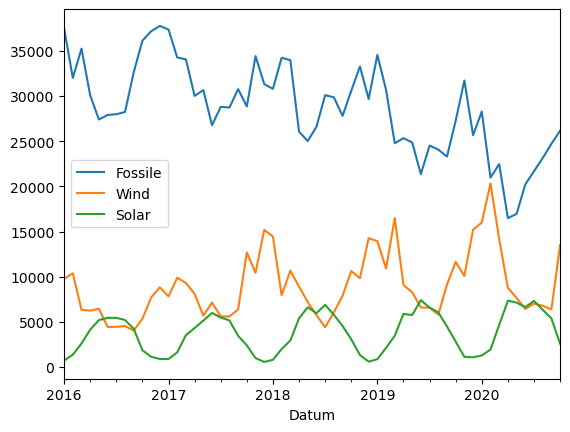

In [21]:
ene.plot()

Pandas verwendet Matplotlib als sein Standard-Plot-Backend, was bedeutet, dass wir die Funktion ene.plot() verwenden können, um Plots zu erstellen, ohne die Matplotlib-Bibliothek explizit zu importieren. Wenn wir ene.plot() aufrufen, erzeugt Pandas ein Matplotlib-Plotobjekt und gibt es an uns zurück.

Wenn wir jedoch den Plot anpassen oder einige der fortgeschrittenen Funktionen von Matplotlib verwenden möchten, müssen wir die Matplotlib-Bibliothek importieren und ihre Funktionen direkt verwenden.

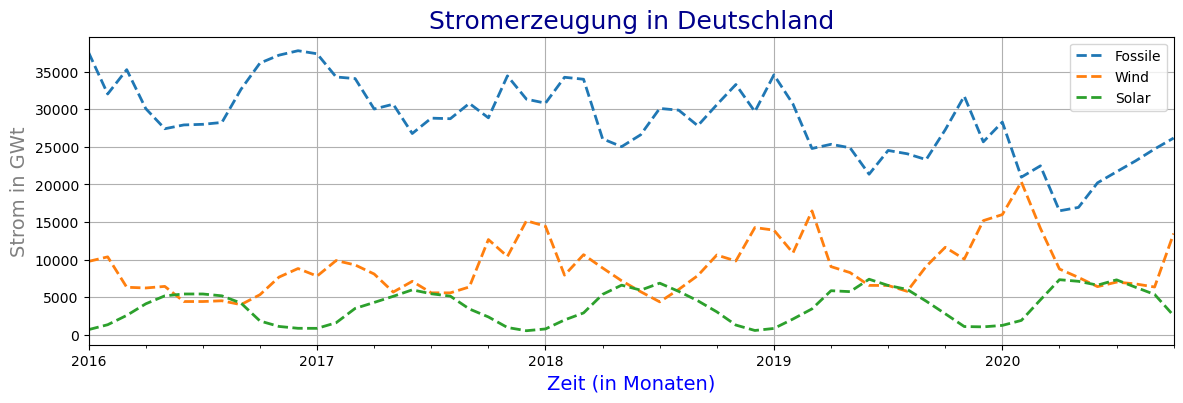

In [22]:
ene.plot(figsize=(14, 4), linewidth=2.0, linestyle='--')
x = plt.xlabel('Zeit (in Monaten)', fontsize=14, color='blue')
y = plt.ylabel('Strom in GWt', fontsize=14, color='grey')
t = plt.title('Stromerzeugung in Deutschland', fontsize=18, color='darkblue')
plt.grid(True)

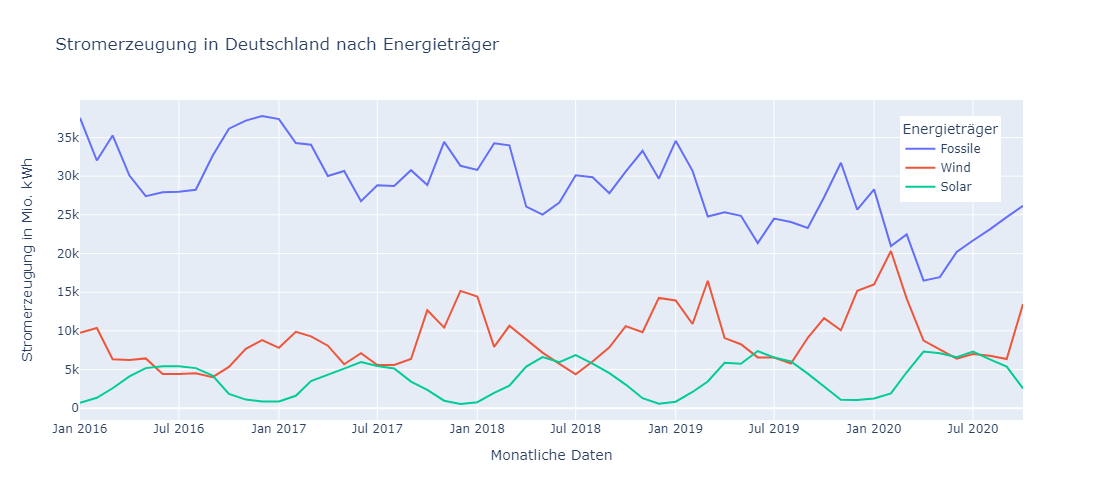

In [30]:
fig = px.line(ene, x=ene.index, y=['Fossile','Wind','Solar'], title='Stromerzeugung in Deutschland nach Energieträger', labels=dict(Datum="Monatliche Daten", value="Stromerzeugung in Mio. kWh", variable="Energieträger"))
fig.update_layout(height=500, legend=dict(yanchor="top", y=0.95, xanchor="left", x=0.87))
fig.show()

<div class="alert alert-info">
    <h5> Aufgabe 1.1.1) Zeitreihen: Daten und Plots </h5><br>
- Kreiere dir einen ähnlichen Datensatz für Haushalt 4 im Juni-Juli 2012 sowie einen für Haushalt 42 in der ersten Februarwoche 2013 aus der Tabelle<br>
- Speichere ihn unter 'em_HH4.csv' bzw. 'em_HH42' ab<br>
- Speichere dir dann zusätzlich den 'ene' und 'elec' Datensatz unter 'ene.csv' bzw. 'elec.csv' ab<br>
    - Kreiere je einen Matplotlib oder Plotly Plot für den Stromverbrauch eines Haushalts für Juni - Juli 2012 <br>
- Sternchenaufgabe 1: Passe den Plot so an, dass Leser sofort verstehen, was dort abgebildet ist<br>
- Sternchenaufgabe 2: Du kannst gern durch plotten versuchen, etwas mehr über die 321 Haushalte herauszufinden<br>
</div>

In [51]:
em_HH4 = elec.loc["2012-06-01 00:00:00":"2012-07-31 23:00:00",['Haushalt4']]
em_HH42 = elec.loc["2013-02-01 00:00:00":"2013-02-07 23:00:00",['Haushalt42']]

In [52]:
em_HH4.to_csv('em_HH4.csv')
em_HH42.to_csv('em_HH42.csv')

In [53]:
ene.to_csv('ene.csv')
elec.to_csv('elec.csv')

<AxesSubplot:xlabel='Zeit'>

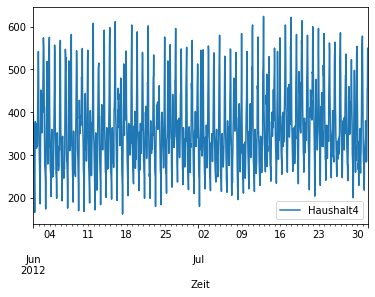

In [54]:
em_HH4.plot()

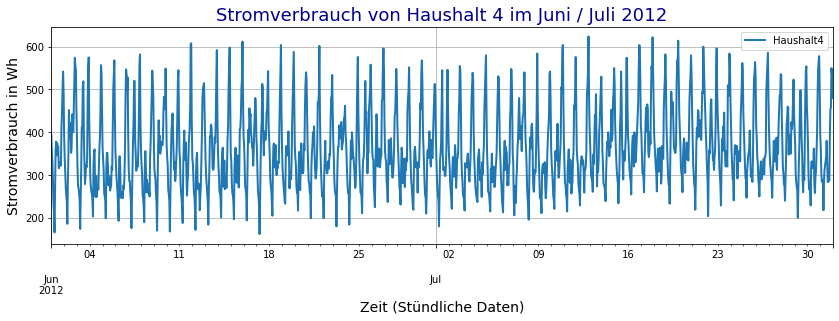

In [58]:
em_HH4.plot(figsize=(14, 4), linewidth=2.0, linestyle='-')
x = plt.xlabel('Zeit (Stündliche Daten)', fontsize=14)
y = plt.ylabel('Stromverbrauch in Wh', fontsize=14)
t = plt.title('Stromverbrauch von Haushalt 4 im Juni / Juli 2012', fontsize=18, color='darkblue')
plt.grid(True)

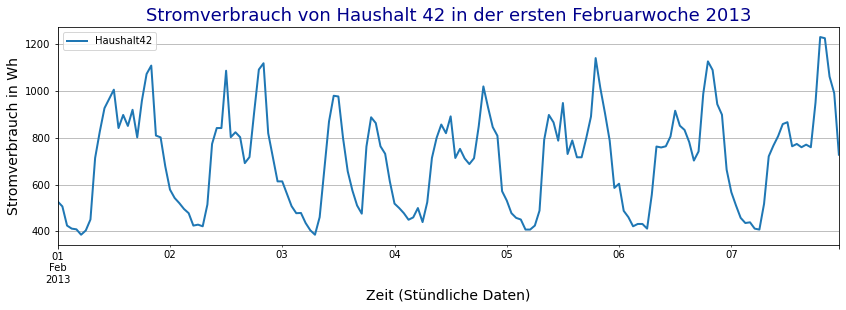

In [59]:
em_HH42.plot(figsize=(14, 4), linewidth=2.0, linestyle='-')
x = plt.xlabel('Zeit (Stündliche Daten)', fontsize=14)
y = plt.ylabel('Stromverbrauch in Wh', fontsize=14)
t = plt.title('Stromverbrauch von Haushalt 42 in der ersten Februarwoche 2013', fontsize=18, color='darkblue')
plt.grid(True)

In [ ]:
# Hier kannst du noch beliebig viele Plots machen.

# 1.2 Zeitreihen vorhersagen

## 1.2.1 Grundlagen und Naiver Ansatz

### Trainings- und Testdaten für Zeitreihen

In [31]:
train_data = ene['Solar'].iloc[:-12]  
one_step = ene['Solar'].iloc[-12:-11]
test_data = ene['Solar'].iloc[-12:]

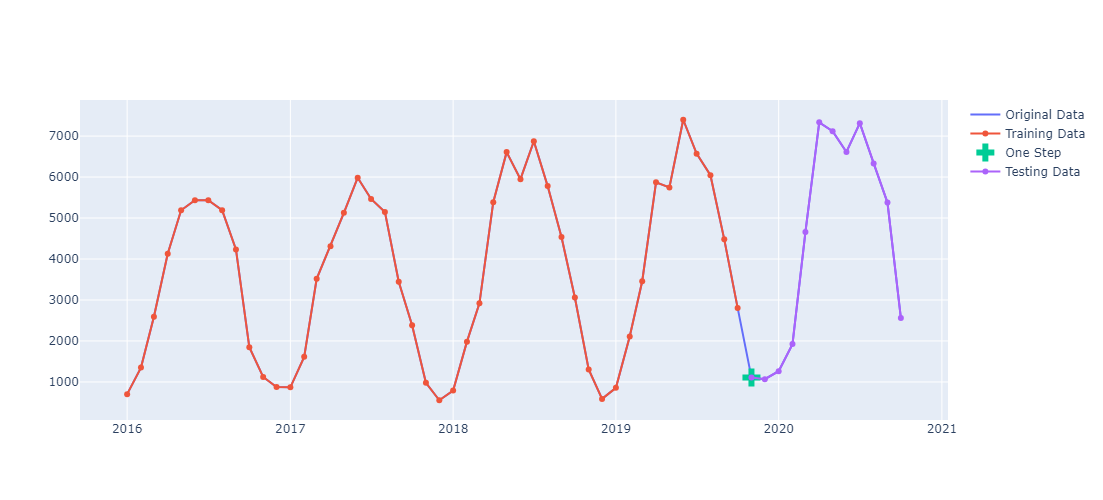

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ene.index, y=ene['Solar'], name='Original Data'))
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=one_step.index, y=one_step, mode='markers', marker=dict(symbol='cross', size=15), name='One Step'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines+markers', name='Testing Data'))
fig.update_layout(height=500)
fig.show()

### Ein-Schritt-Vorhersage

In [34]:
train_data.tail()

Datum
2019-06-01    7399
2019-07-01    6572
2019-08-01    6045
2019-09-01    4480
2019-10-01    2807
Name: Solar, dtype: int64

In [35]:
naive_one_step_forecast = pd.Series(train_data.iloc[-1], index=one_step.index)

In [36]:
naive_one_step_forecast

Datum
2019-11-01    2807
dtype: int64

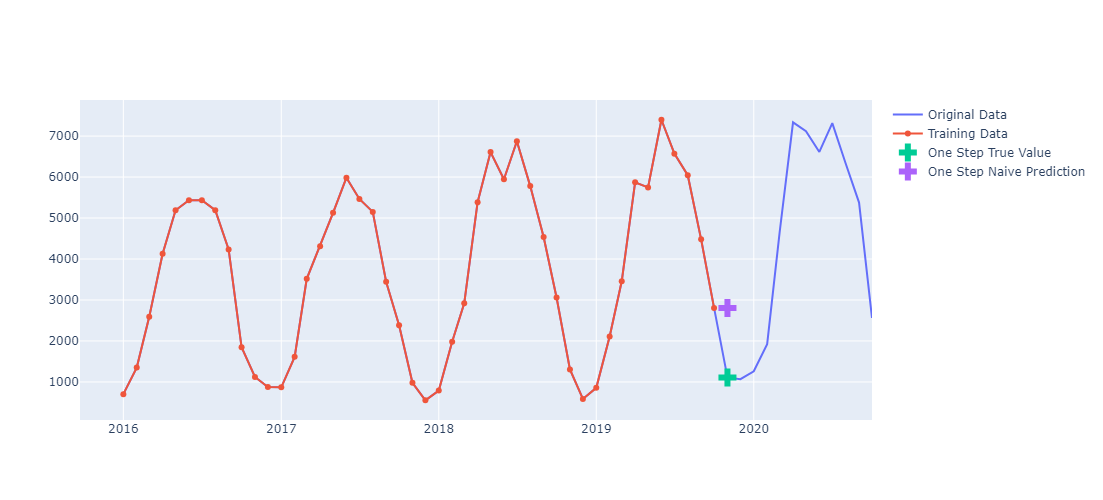

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ene.index, y=ene['Solar'], name='Original Data'))
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=one_step.index, y=one_step, mode='markers', marker=dict(symbol='cross', size=15), name='One Step True Value'))
fig.add_trace(go.Scatter(x=one_step.index, y=naive_one_step_forecast, mode='markers', marker=dict(symbol='cross', size=15), name='One Step Naive Prediction'))
fig.update_layout(height=500)
fig.show()

In [39]:
mse = mean_squared_error(one_step, naive_one_step_forecast)
mae = mean_absolute_error(one_step, naive_one_step_forecast)
print('Test MSE: ', mse, "Test MAE: ", mae)

Test MSE:  2883204.0 Test MAE:  1698.0


### Naive-Ein-Schritt-Vorhersage für expandierendes Fenster

In [40]:
cont_naive_one_step_forecast = pd.Series(ene['Solar'].shift(periods=1, fill_value = 112), index=test_data.index)
cont_naive_one_step_forecast

Datum
2019-11-01    2807
2019-12-01    1109
2020-01-01    1066
2020-02-01    1261
2020-03-01    1923
2020-04-01    4657
2020-05-01    7335
2020-06-01    7121
2020-07-01    6613
2020-08-01    7316
2020-09-01    6330
2020-10-01    5378
Name: Solar, dtype: int64

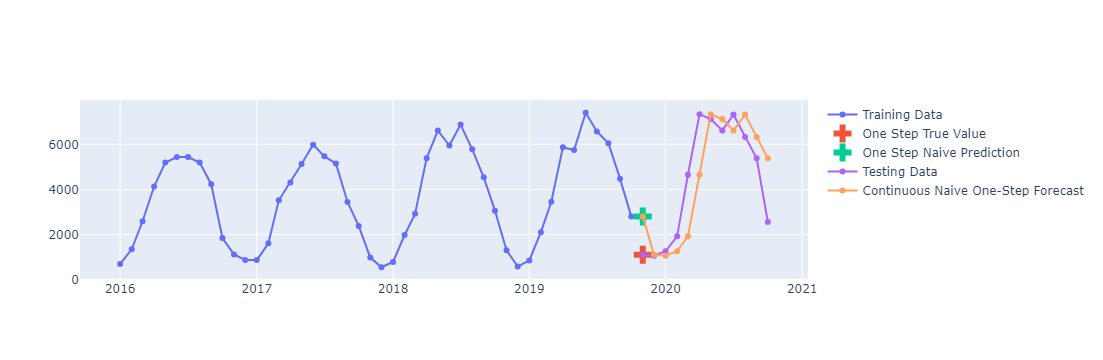

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=one_step.index, y=one_step, mode='markers', marker=dict(symbol='cross', size=15), name='One Step True Value'))
fig.add_trace(go.Scatter(x=one_step.index, y=naive_one_step_forecast, mode='markers', marker=dict(symbol='cross', size=15), name='One Step Naive Prediction'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines+markers', name='Testing Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=cont_naive_one_step_forecast, mode='lines+markers', name='Continuous Naive One-Step Forecast'))
fig.show()

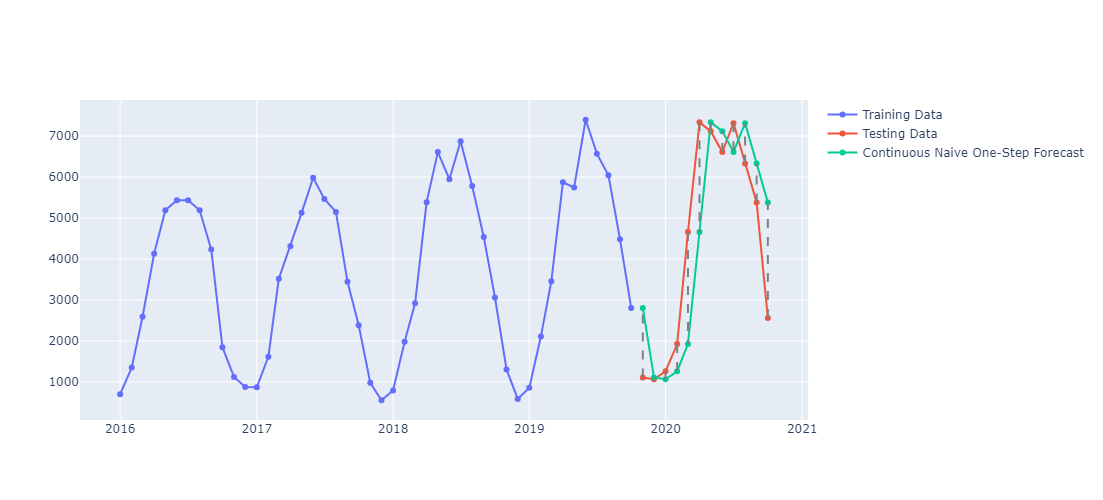

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines+markers', name='Testing Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=cont_naive_one_step_forecast, mode='lines+markers', name='Continuous Naive One-Step Forecast'))
for i in range(len(test_data)):
    fig.add_shape(type='line',
                  x0=test_data.index[i], y0=test_data[i],
                  x1=test_data.index[i], y1=cont_naive_one_step_forecast[i],
                  line=dict(color='gray', dash='dash'))
fig.update_layout(height=500)
fig.show()

In [43]:
mse = mean_squared_error(test_data, cont_naive_one_step_forecast)
mae = mean_absolute_error(test_data, cont_naive_one_step_forecast)
print('Test MSE: ', mse, "Test MAE: ", mae)

Test MSE:  2384985.0 Test MAE:  1182.5


### (Rekursive) Mehrschritt-Vorhersage = (Recursive) Multistep Forecast

In [44]:
naive_multistept_forecast = pd.Series(train_data.iloc[-1], index=test_data.index)

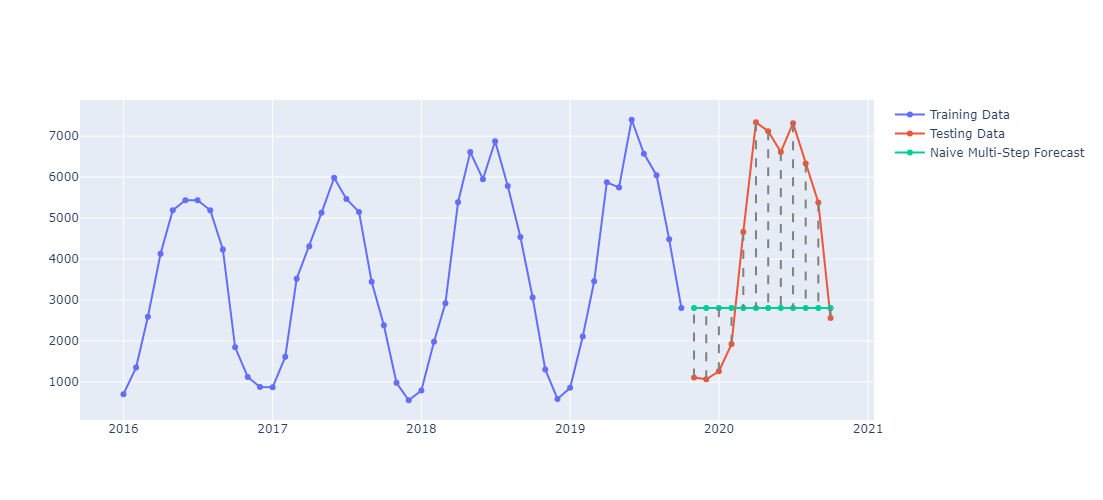

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines+markers', name='Testing Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=naive_multistept_forecast, mode='lines+markers', name='Naive Multi-Step Forecast'))
for i in range(len(test_data)):
    fig.add_shape(type='line',
                  x0=test_data.index[i], y0=test_data[i],
                  x1=test_data.index[i], y1=naive_multistept_forecast[i],
                  line=dict(color='gray', dash='dash'))
fig.update_layout(height=500)
fig.show()

In [47]:
mse = round(mean_squared_error(test_data, naive_multistept_forecast),1)
mae = round(mean_absolute_error(test_data, naive_multistept_forecast),1)
print('Test MSE: ', mse, "Test MAE: ", mae)

Test MSE:  8793378.3 Test MAE:  2601.3


<div class="alert alert-info">
    <h5> Aufgabe 1.2.1) Zeitreihen vorhersagen: Grundlagen und Naiver Ansatz </h5><br>
- Teile den Winddatensatz in Trainings und Testdaten ein mit 12 Monaten im Testzeitraum.<br>
- Erstelle eine kontinuierliche Naive Vorhersage und eine Naive Mehrschrittvorhersage für die Windzeitreihe<br>
- Visualisiere beide neben den echten Daten.<br>
- Sternchenaufgabe: Du kannst dies auch für den Stromverbrauch von Haushalt 8 im Mai 2012 machen<br>
</div>

In [48]:
train_data = ene['Wind'].iloc[:-12]  
one_step = ene['Wind'].iloc[-12:-11] 
test_data = ene['Wind'].iloc[-12:] 

In [49]:
cont_naive_one_step_forecast = pd.Series(ene['Wind'].shift(periods=1, fill_value = ene.loc['2016-01-01','Wind']), index=test_data.index)

In [50]:
naive_multistept_forecast = pd.Series(train_data.iloc[-1], index=test_data.index)

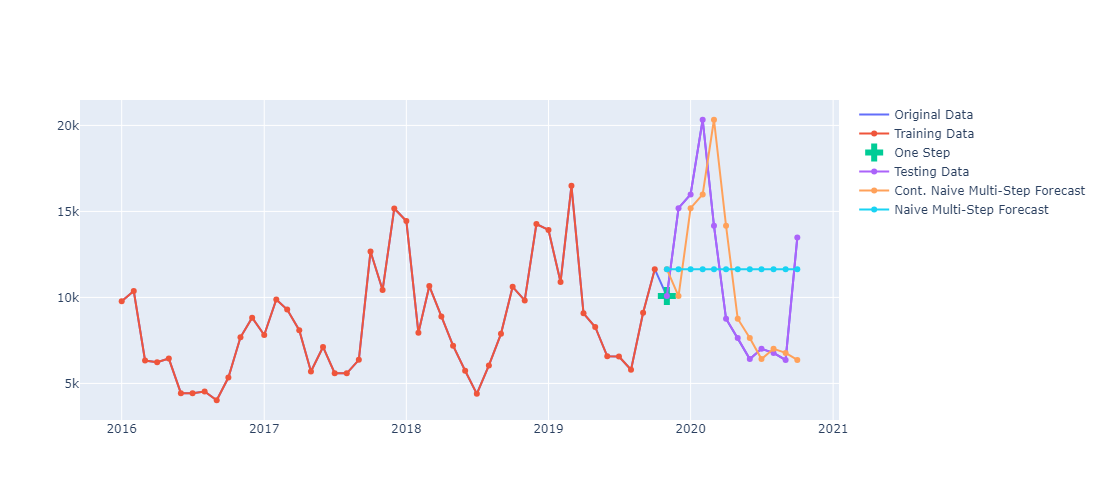

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ene.index, y=ene['Wind'], name='Original Data'))
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines+markers', name='Training Data'))
fig.add_trace(go.Scatter(x=one_step.index, y=one_step, mode='markers', marker=dict(symbol='cross', size=15), name='One Step'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines+markers', name='Testing Data'))
fig.add_trace(go.Scatter(x=test_data.index, y=cont_naive_one_step_forecast, mode='lines+markers', name='Cont. Naive Multi-Step Forecast'))
fig.add_trace(go.Scatter(x=test_data.index, y=naive_multistept_forecast, mode='lines+markers', name='Naive Multi-Step Forecast'))
fig.update_layout(height=500)
fig.show()

In [ ]:
train_data = ene['Wind'].iloc[:-12]  
one_step = ene['Wind'].iloc[-12:-11] 
test_data = ene['Wind'].iloc[-12:] 

In [57]:
# Dein Code